# Air Voids

In [1]:
#%% IMPORTS
#BASICS
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import absolute
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from IPython.display import display, Markdown, Latex
pd.options.display.max_columns = None

#STATISTICS
from scipy.stats import normaltest
from scipy import stats

#ML TRAINING AND DATA PREPROCESSING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures

#ML MODELS
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

#MODEL EVALUATION
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_predict

#METRICS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. Methods 

In [2]:
#Eliminate Outliers based on the interquantile
#datFrame: Data frame where the outliers will be eliminated.
#columnName: the name of the column where the outliers will be identified.
def eliminateOutliers (dataFrame, columnName):
    Q1 = dataFrame[columnName].quantile(0.25)
    Q3 = dataFrame[columnName].quantile(0.75)
    IQR = Q3 - Q1
    print('Initial dataframe size: '+str(dataFrame.shape))
    dataFrame = dataFrame[(dataFrame[columnName] < (Q3 + 1.5 * IQR)) & (dataFrame[columnName] > (Q1 - 1.5 * IQR))]
    print('Final dataframe size: '+str(dataFrame.shape))
    return dataFrame

In [3]:
# Create the boxplot graphs for the categorical variables
# dataFrame: Data frame associated to the property of interest (dfAirVoids, dfMS, dfMF, dfITS, dfTSR)
# propertyOfInterest: the name of the column where the property of interest is located.
# columnName1...4: The categorical columns to evaluate.
def displayBoxPlotGraphs (dataFrame, propertyOfInterest, columnName1, columnName2, columnName3, columnName4):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
    sns.boxplot(y = propertyOfInterest, x = columnName1, data=dataFrame,  orient='v' , ax=ax1)
    sns.boxplot(y = propertyOfInterest, x = columnName2, data=dataFrame,  orient='v' , ax=ax2)
    sns.boxplot(y = propertyOfInterest, x= columnName3, data=dataFrame,  orient='v' , ax=ax3)
    sns.boxplot(y= propertyOfInterest, x= columnName4, data=dataFrame,  orient='v' , ax=ax4)

##  2. Data Import 

In [4]:
#%%DATA READING AND INITIAL PREPROCESSING
numericColumns = ['Aggregate absorption (%)',
                  'Apparent specific gravity',
                    0.075,
                    0.3,
                    0.6,
                    2.36,
                    4.75,
                    9.5,
                    12.5,
                    19,
                    'Plastic particle size (mm)',
                    'Mixing speed (RPM)',
                    'Mixing Temperature',
                    'Mixing Time (hours)',
                    'Plastic Addition by bitumen weight (%)',
                    'Bitumen content in the sample'
                    ]
categoricalColumns = ['Modified asphalt Mix?',
                      'Agreggate Type',
                    'Aggregate absorption [%]',
                    'Filler used',
                    'Consolidated bitumen penetration grade',
                    'New Plastic Type',
                    'Plastic pretreatment',
                    'Plastic shape',
                    'Plastic Size',
                    'Mixing Process',
                    'Aggregates replacement ?',
                    'Bitumen replacement?',
                    'Filler replacement',
                    'Property',
                    'Units']
#It returns the dataframe of interes based on the property - 'AirVoids', 'MS', 'MF', 'ITS', 'TSR'
def returnDf (propertyOfInterest):
    df = pd.read_excel('fileML.xlsx', sheet_name = propertyOfInterest, engine='openpyxl')
    df = df.set_index(propertyOfInterest + ' ID')
    df.loc[:,:'Units'] = df.loc[:,:'Units'].applymap(str)
    df.loc[:,:'Units'] = df.loc[:,:'Units'] .applymap(str.strip)
    df.replace('NS', np.nan, inplace = True)
    df[numericColumns] = df[numericColumns].replace('N/a', 0).astype(float)
    df.columns = df.columns.astype(str)
    return df

In [5]:
dfAirVoids = returnDf('AirVoids')

## 3. Data Exploration
###  3.1 Total Sample

In [6]:
dfAirVoids = eliminateOutliers(dfAirVoids, 'Air voids of the sample (%)')

Initial dataframe size: (305, 34)
Final dataframe size: (288, 34)


In [ ]:
dfAirVoids.info()

In [ ]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['Air voids of the sample (%)']

In [ ]:
dfAirVoids.describe(include = 'all')

In total, there is $\color{red}{\text{288}}$ observations. Let's see if there is any correlation with the continual and categorical variables. The mean of $\color{red}{\text{Air voids}}$, which is the common value for the optimum asphalt mix design.

In [ ]:
scatter_matrix(dfAirVoids[['Aggregate absorption (%)', 'Apparent specific gravity', 'Bitumen content in the sample', 'Air voids of the sample (%)']], figsize=(10, 10))
plt.show()

It is possible to see a negative correlation between $\color{red}{\text{Bitumen Content}}$  and $\color{red}{\text{Air Voids}}$. This makes sense because higher bitumen quantities will fill more voids in the mixture.

Among the categorical variables, we will initially focus on the general ones that might have an effect on air voids: $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Filler used}}$ and $\color{red}{\text{Bitumen Grade}}$

In [ ]:
displayBoxPlotGraphs(dataFrame = dfAirVoids, propertyOfInterest = "Air voids of the sample (%)", columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

Within the  $\color{red}{\text{Aggregate type}}$, although it exists differences -especially with the Ophitic- this data migh not be robust enough due to the sample size of this type of aggregate. It happens the same with the  $\color{red}{\text{Bitumen type}}$, where only  $\color{purple}{\text{5}}$ observations used the 40/50 bitumen. The  $\color{red}{\text{addition of plastic}}$ seems to have not strong influence in the air voids.

In [ ]:
#CORRELATION:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfAirVoids.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Air Voids', fontdict={'fontsize':12}, pad=12);

###  3.2 Modified mixtures

In [ ]:
dfAirVoidsModvsUnmod = dfAirVoids [['Modified asphalt Mix?', 'Air voids of the sample (%)']]
dfAirVoidsModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

In [ ]:
dfAirVoidsModified = dfAirVoids[dfAirVoids['Modified asphalt Mix?']=='Yes']
dfAirVoidsModified.describe(include = "all")

In [ ]:
scatter_matrix(dfAirVoidsModified[columnsOfInteres], figsize=(25, 20))
plt.show()

In [ ]:
#CORRELATION:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfAirVoidsModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [ ]:
displayBoxPlotGraphs(dataFrame = dfAirVoidsModified, propertyOfInterest = "Air voids of the sample (%)", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

Not much difference among dry and wet

###  3.3 Wet vs. Dry Mixing

In [ ]:
dfAirVoidsWetvsDry = dfAirVoidsModified [['Mixing Process', 'Air voids of the sample (%)']]
dfAirVoidsWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

In [ ]:
sns.pairplot(dfAirVoidsModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **Air Voids summary:**

*   There are missing values mainly in $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{Aggregate type}}$ and $\color{red}{\text{filler used}}$.
*   Total sample: # observations = 288, Mean = 4, Standard deviation = 0.98 
*   Sample with asphalt modified: # observations = 228, Mean = 3.94, Standard deviation = 1.017
*   It seems that there will be a strong correlation with $\color{red}{\text{Aggregates gradation}}$.
*   Dry vs. Wet:
    *   Not strong difference between dry and wet.
    *   Mean in wet = 3.64, Mean in dry = 4.16.


## 4. Data Pre-processing

In [ ]:
dfAirVoids.info()

*   Process for dealing with missing categorical values:

    1.  I will eliminate the rows with Nan values in the column $\color{red}{\text{New Plastic Type}}$. In total, there is 24 missing values, which represent 8.33% of the sample
    2.  Replace the 'N/a' value when there is no modifiation of the asphalt mix.

*   Process for dealing with missing numeric values:

    *   The imputer used was the multivariable imputer, and the estimator was the ExtraTreeRegressor ([link][1]).
    By using this estimator, I did not get any negative values among the missing features, and it presents a low MSE value.
    
[1]:https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py  

In [7]:
#Categorical Variables
dfAirVoidsCleaned = dfAirVoids.drop(['Article ID', 
                                    'Global ID',
                                    'Modified asphalt Mix?',
                                    'Agreggate Type', 
                                    'Apparent specific gravity', 
                                    'Filler used', 
                                    'Bitumen Type Penetration Grade', 
                                    'Property', 
                                    'Units', 
                                    'Plastic Size' ], axis = 1)
dfAirVoidsCleaned = dfAirVoidsCleaned.replace('N/a', 0)
dfAirVoidsCleaned = dfAirVoidsCleaned.dropna(subset=['New Plastic Type'])
dfAirVoidsCleaned = pd.get_dummies(dfAirVoidsCleaned, columns=['New Plastic Type'], drop_first=False)
dfAirVoidsCleaned = pd.get_dummies(dfAirVoidsCleaned, drop_first=True)
dfAirVoidsCleaned = dfAirVoidsCleaned.drop(['New Plastic Type_0'], axis = 1)

In [8]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state = 123), max_iter=50,random_state = 123)
n = imputer.fit_transform(dfAirVoidsCleaned)
dfAirVoidsCleanedImputed = pd.DataFrame(n, columns = list(dfAirVoidsCleaned.columns))
print ('There is '+str(sum(n < 0 for n in dfAirVoidsCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

There is 0 negative values in the new Dataframe


In [9]:
dfAirVoidsCleanedImputed['New Plastic Type_Nylon'] = dfAirVoidsCleanedImputed['New Plastic Type_Nylon'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PE'] = dfAirVoidsCleanedImputed['New Plastic Type_PE'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PET'] = dfAirVoidsCleanedImputed['New Plastic Type_PET'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PP'] = dfAirVoidsCleanedImputed['New Plastic Type_PP'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PS'] = dfAirVoidsCleanedImputed['New Plastic Type_PS'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PU'] = dfAirVoidsCleanedImputed['New Plastic Type_PU'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_Plastic Mix'] = dfAirVoidsCleanedImputed['New Plastic Type_Plastic Mix'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed = dfAirVoidsCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [10]:
dfAirVoidsCleanedImputed.columns

Index(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'Air voids of the sample (%)',
       'New Plastic Type_Nylon', 'New Plastic Type_PE', 'New Plastic Type_PET',
       'New Plastic Type_PP', 'New Plastic Type_PS', 'New Plastic Type_PU',
       'New Plastic Type_Plastic Mix',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'],
      dtype='object')

In [11]:
 #Feature Scaling
 scaler = MinMaxScaler()
 dfAirVoidsCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfAirVoidsCleanedImputed), columns = list(dfAirVoidsCleanedImputed.columns))
 dfAirVoidsCleanedImputedScaled.to_clipboard()

In [12]:
dfAirVoidsCleanedImputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 33 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       264 non-null    float64
 1   0.075                                          264 non-null    float64
 2   0.3                                            264 non-null    float64
 3   0.6                                            264 non-null    float64
 4   2.36                                           264 non-null    float64
 5   4.75                                           264 non-null    float64
 6   9.5                                            264 non-null    float64
 7   12.5                                           264 non-null    float64
 8   19                                             264 non-null    float64
 9   Plastic particle size (mm)                     264 non

## 5. Model Training

In [13]:
min = dfAirVoidsCleanedImputed['Air voids of the sample (%)'].min()
max = dfAirVoidsCleanedImputed['Air voids of the sample (%)'].max()
print('The min value is: '+str(min)+'. The max value is: '+str(max))

The min value is: 1.84. The max value is: 6.7


In [14]:
#Method that print the best parameters, R2 and MSE based on a grid search.
def printBestModelAdv (grid, estimator = n, advancedAnalysis = False):
    min = dfAirVoidsCleanedImputed['Air voids of the sample (%)'].min()
    max = dfAirVoidsCleanedImputed['Air voids of the sample (%)'].max()
    mse = -grid.best_score_
    print('Best Parameters:' , grid.best_params_)
    print('Best Test MSE: ' + str(mse))
    print('Std of the Test MSE:' + str(grid.cv_results_['std_test_neg_mean_squared_error'][grid.best_index_]))
    print('Best Test RMSE: ' +str(math.sqrt(mse)))
    print('Best Test scaled RMSE: ' +str((math.sqrt(mse)*(max-min))+min))
    print('Best Test scaled MSE: ' +str(((math.sqrt(mse)*(max-min))+min)**2)) 
    print('Best Test R2: ' + str(grid.cv_results_['mean_test_r2'][grid.best_index_]))
    if (advancedAnalysis):
        bestEstimator = estimator
        bestEstimator.fit(X_train, y_train)
        predictionsTrain = bestEstimator.predict(X_train)
        df = pd.DataFrame({'predictions':predictionsTrain, 'original': y_train})
        df.plot.hist(bins=10, alpha=0.5)
        unScaledDf = (df*(max-min))+min
        print (unScaledDf.describe())

In [15]:
X = dfAirVoidsCleanedImputedScaled.loc[:, dfAirVoidsCleanedImputedScaled.columns != 'Air voids of the sample (%)']
X.columns = X.columns.astype(str)
y = dfAirVoidsCleanedImputedScaled.loc[:,'Air voids of the sample (%)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 123)

In [16]:
y_train_new = y_train.to_frame()
y_train_new['y_train_unscaled'] = (y_train*(max-min))+min

In [17]:
y_train_new.describe()

,Air voids of the sample (%),y_train_unscaled
count,211.000000,211.000000
mean,0.464582,4.097867
std,0.193989,0.942785
min,0.000000,1.840000
25%,0.341564,3.500000
50%,0.438272,3.970000
75%,0.548354,4.505000
max,1.000000,6.700000


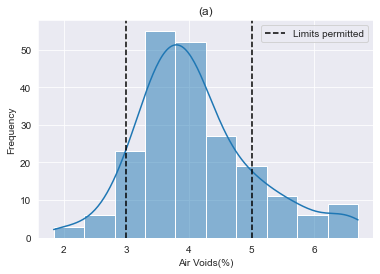

In [18]:
sns.set_style('darkgrid')
fig, ax = plt.subplots()
sns.histplot(x=y_train_new["y_train_unscaled"], bins=10, kde=True, ax = ax)
ax.set(xlabel='Air Voids(%)', ylabel='Frequency')
ax.axvline(x=3, label = 'Limits permitted', linestyle = '--', color='k')
ax.axvline(x=5, linestyle = '--', color='k')
ax.set_title('(a)')
ax.legend()
plt.show()

### 5.1 Model Evaluation
#### Linear Model

In [ ]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv = cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid) 

#### Lasso Linear Model


In [ ]:
param_grid = {'alpha': [0.001,1, 10, 15, 30, 50, 100],
            'fit_intercept':[True, False],
            'positive': [True, False]}
grid = GridSearchCV(Lasso(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Ridge linear regression model

In [ ]:
param_grid = {'alpha': [7, 8, 10,100],
'fit_intercept': [True, False],
'solver': [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(Ridge(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Linear Elastic Net

In [ ]:
param_grid = {'alpha': [0.01,1,2,3,4],
'fit_intercept': [True, False]}
grid = GridSearchCV(ElasticNet(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Polynomial Model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'linearregression__fit_intercept': [True, False],
'linearregression__positive':[True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Lasso Polynomial Model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
            'lasso__alpha': [1,2, 3, 10, 15, 30],
            'lasso__fit_intercept':[True, False],
            'lasso__positive': [True, False],
            'lasso__max_iter': [2000,3000, 3500]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Ridge polynomial regression

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'ridge__alpha':[20,30,50, 60],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'auto']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Support vector regression

In [ ]:
param_grid = {
    'kernel':['linear','rbf', 'sigmoid', 'poly'],
    'degree':[2,3,4],
    'C':[0.01,1,5,10],
    'epsilon':[0.1,0.2, 1, 1.5]
}
grid = GridSearchCV(SVR(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Decision tree regressor

In [ ]:
param_grid = {
    'max_depth':[1,2,3,5,10,30],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[0.4,1,2]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Random Forest


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
grid = RandomizedSearchCV(RandomForestRegressor(), 
                        random_grid, 
                        cv=cv, 
                        scoring=['neg_mean_squared_error', 'r2'], 
                        refit='neg_mean_squared_error', 
                        n_iter=10,
                        )
grid.fit(X_train, y_train)
printBestModelAdv(grid, RandomForestRegressor(**grid.best_params_), True)

#### Extra tree regressor

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(ExtraTreesRegressor(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error', n_iter=10)
grid.fit(X_train, y_train)
printBestModelAdv(grid, ExtraTreesRegressor(**grid.best_params_), True)

#### XG Boost Regressor

In [ ]:
XGBoostModel = XGBRegressor(random_state=123)
scores = cross_val_score(XGBoostModel, X_train, y_train , scoring = 'neg_mean_squared_error', cv = cv)
scores = np.absolute(scores)
print (scores.mean())

In [ ]:
XGModel = XGBRegressor(random_state = 1,
                        eta = 0.1,
                        max_depth = 6,
                        min_child_weight =1,
                        max_delta_step = 0,
                        gamma = 0,
                        subsample = 1,
                        colsample_bytree = 1,
                        colsample_bylevel = 1,
                        colsample_bynode = 1, 
                        reg_lambda = 13,
                        alpha = 0,
                        tree_method = 'approx',
                        n_estimators = 100)
modelEvaluation(XGModel, 'XGModel')

In [ ]:
param_grid = {
    'eta':[0.09],
    'max_depth':[5],
    'max_delta_step': [9],
    'gamma' : [0.001],
    'lambda' : [8],
    'alpha' : [0],
    'n_estimators': [100,300,500,1000]
}
grid =GridSearchCV(XGBRegressor(random_state=123), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid, XGBRegressor(**grid.best_params_), True)

In [ ]:
X_train.columns

In [19]:
X_train2 = X_train.copy()
X_train2.rename(columns={'0.075':'Grad. Sieve size 0.075', '0.3':'Grad. Sieve size 0.3', '0.6':'Grad. Sieve size 0.6', '2.36':'Grad. Sieve size 2.36',                                '4.75':'Grad. Sieve size 4.75','9.5':'Grad. Sieve size 9.5', '12.5':'Grad. Sieve size 12.5', '19':'Grad. Sieve size 19', 
                        'Plastic particle size (mm)':'Plastic size', 'Mixing speed (RPM)':'Mixing speed',
                        'Mixing Time (hours)':'Mixing Time',
                        'Bitumen content in the sample':'Bitumen content', 'New Plastic Type_Nylon':'Plastic Type_Nylon',
                        'New Plastic Type_PE':'Plastic Type_PE', 'New Plastic Type_PET':'Plastic Type_PET', 'New Plastic Type_PP':'Plastic Type_PP',
                        'New Plastic Type_PS':'Plastic Type_PS', 'New Plastic Type_PU':'Plastic Type_PU',
                        'New Plastic Type_Plastic Mix':'Plastic Type_Plastic Mix',
                        'Consolidated bitumen penetration grade_50/70':'Bitumen grade_50/70',
                        'Consolidated bitumen penetration grade_70/100':'Bitumen grade_70/100',
       }, inplace=True)

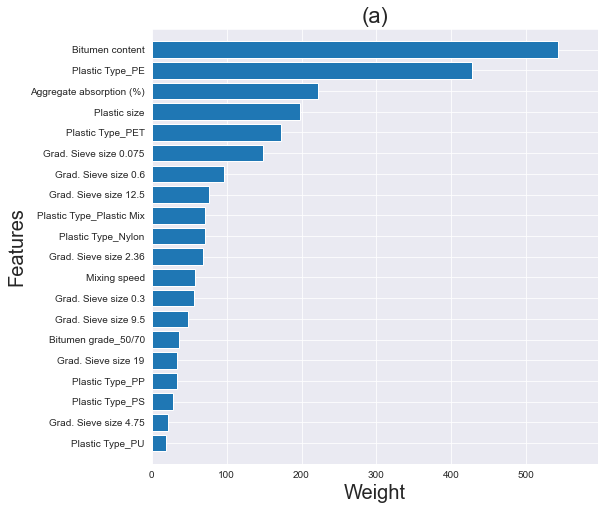

In [43]:
#Graph employed for selecting important features during tunning
XGBoostModel = XGBRegressor(reg_alpha=0, eta=0.09, gamma=0.001, reg_lambda=8, max_delta_step=9, n_estimators=300, random_state=123)
XGBoostModel.fit(X_train2,y_train)
ax = plot_importance(XGBoostModel, height=0.8, importance_type='weight', show_values=False, title=None, max_num_features = 20)
fig = ax.figure
plt.xlabel('Weight', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('(a)',fontsize= 22)
fig.set_size_inches(8,8)

*The Gain is the most relevant attribute to interpret the relative importance of each feature.* [Reference](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)

## 6. Best Model Tunning

In [22]:
X_train.columns = X_train.columns.astype(str)
cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 123)

### 6.1. Feature selection

In [23]:
features_MSE = {}
def addMSE (columns, string):
    cv_results = cross_validate(XGBRegressor(reg_alpha=0, 
                                eta=0.09, 
                                gamma=0.001, 
                                reg_lambda=8, 
                                max_delta_step=9, 
                                n_estimators=300, 
                                random_state = 123), X_train[columns], y_train, cv = cv, scoring = ['neg_mean_squared_error'])
    MSE = np.average(-cv_results['test_neg_mean_squared_error'])
    features_MSE[string] = MSE

In [24]:
X_train.columns

Index(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_Nylon',
       'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU',
       'New Plastic Type_Plastic Mix',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'],
      dtype='object')

In [25]:
addMSE(['Bitumen content in the sample'], 'Bitumen cont.')

In [26]:
addMSE(['Bitumen content in the sample', 
       'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU','New Plastic Type_Plastic Mix'], 
       'Bitumen cont. \n Plastic Type')

In [27]:
addMSE(['Bitumen content in the sample', 
       'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU','New Plastic Type_Plastic Mix', 
       'Aggregate absorption (%)'], 
       'Bitumen cont. \n Plastic Type \n Aggregates abs.')

In [28]:
addMSE(['Bitumen content in the sample', 
       'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU','New Plastic Type_Plastic Mix', 
       'Aggregate absorption (%)', 'Plastic particle size (mm)'], 
       'Bitumen cont. \n Plastic Type \n Aggregates abs. \n Plastic size')

In [29]:
addMSE(['Bitumen content in the sample', 
       'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU','New Plastic Type_Plastic Mix', 
       'Aggregate absorption (%)', 'Plastic particle size (mm)',
       '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19'], 
       'Bitumen cont. \n Plastic Type \n Aggregates abs. \n Plastic size \n Gradation')

In [30]:
addMSE(['Bitumen content in the sample', 
       'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU','New Plastic Type_Plastic Mix', 
       'Aggregate absorption (%)', 'Plastic particle size (mm)',
       '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Mixing speed (RPM)'], 
       'Bitumen cont. \n Plastic Type \n Aggregates abs. \n Plastic size \n Gradation \n Mixing Speed')

In [31]:
addMSE(['Bitumen content in the sample', 
       'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU','New Plastic Type_Plastic Mix', 
       'Aggregate absorption (%)', 'Plastic particle size (mm)',
       '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Mixing speed (RPM)',
       'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',], 
       'Bitumen cont. \n Plastic Type \n Aggregates abs. \n Plastic size \n Gradation \n Mixing Speed \n Bitumen type')

In [32]:
addMSE(['Bitumen content in the sample', 
       'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU','New Plastic Type_Plastic Mix', 
       'Aggregate absorption (%)', 'Plastic particle size (mm)',
       '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Mixing speed (RPM)',
       'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
       'Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded'], 
       'Bitumen cont. \n Plastic Type \n Aggregates abs. \n Plastic size \n Gradation \n Mixing Speed \n Bitumen type \n Plastic shape')

In [33]:
addMSE(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_Nylon',
       'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU',
       'New Plastic Type_Plastic Mix',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'], 
       'All Features')

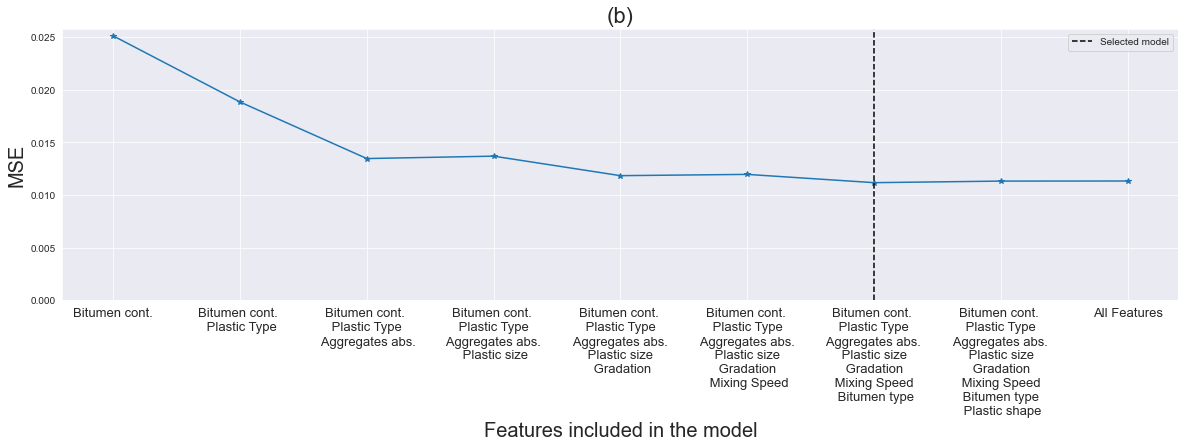

In [42]:
 plt.rcParams["figure.figsize"] = (20,5)
 plt.plot(features_MSE.keys(), features_MSE.values(), marker = '*') 
 plt.ylim(ymin = 0)
 plt.axvline(x='Bitumen cont. \n Plastic Type \n Aggregates abs. \n Plastic size \n Gradation \n Mixing Speed \n Bitumen type', ymin=0, ymax=1, color = 'k', ls = '--' , label='Selected model')
 plt.ylabel('MSE', fontsize = 20)
 plt.xlabel('Features included in the model', fontsize = 20)
 plt.xticks(fontsize= 13) 
 plt.title('(b)', fontsize=22)
 plt.legend()
 plt.show()

## 6.2 Tunning

In [ ]:
X_train =  X_train[['Bitumen content in the sample', 
       'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU','New Plastic Type_Plastic Mix', 
       'Aggregate absorption (%)', 'Plastic particle size (mm)',
       '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Mixing speed (RPM)',
       'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
        ]]
X_test = X_test [['Bitumen content in the sample', 
       'New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU','New Plastic Type_Plastic Mix', 
       'Aggregate absorption (%)', 'Plastic particle size (mm)',
       '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Mixing speed (RPM)',
       'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
        ]]

### 6.3 Final model evaluation on test set

In [ ]:
def modelEvaluation (model, Title):
    min = dfAirVoidsCleanedImputed['Air voids of the sample (%)'].min()
    max = dfAirVoidsCleanedImputed['Air voids of the sample (%)'].max()
    #Model Fitting
    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)
    #Model Evaluation
    r2_test = r2_score(y_test, predictions_test)
    mse_test = mean_squared_error(y_test, predictions_test)
    rmse_test_unscaled = (math.sqrt(mse_test)*(max-min))+min
    plt.figure(figsize=(7,7))
    #Model Plotting
    plt.scatter(y_test, predictions_test, c='crimson')
    plt.plot([(1,1), (0,0)], [(1,1), (0,0)], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.xlim (0,1)
    plt.ylim (0,1)
    plt.ylabel('Predictions - ' + Title, fontsize=18)
    plt.annotate('R2 = '+str(round(r2_test,3)), xy = (0.6,0.3), fontweight = 'bold', fontsize = 'xx-large')
    plt.annotate('RMSE = '+str(round(rmse_test_unscaled,3)), xy = (0.6,0.25), fontweight = 'bold', fontsize = 'xx-large')
    plt.show()
    return predictions_test

In [ ]:
XGModel = XGBRegressor(reg_alpha=0, eta=0.09, gamma=0.001, reg_lambda=8, max_delta_step=9, n_estimators=300, random_state = 1)
predictions_XGModel = modelEvaluation(XGModel, 'XGModel')

P-value is higher than 0.05, so it the come from the same distibuition

In [ ]:
XGModel.get_params

In [ ]:
extraTreeModel = ExtraTreesRegressor(n_estimators=600, min_samples_split=2,min_samples_leaf=1, max_features='auto', max_depth=30, bootstrap=True, random_state=123)
predictions_ExtraTrees = modelEvaluation(extraTreeModel, 'Extra Trees model')

In [ ]:
stats.ks_2samp(y_test, predictions_XGModel, alternative='two-sided')

In [ ]:
RFModel = RandomForestRegressor(n_estimators=1000,min_samples_split=2, min_samples_leaf=2, max_features='auto', max_depth=50, bootstrap=True, random_state=123)
predictions_RandomForest = modelEvaluation(RFModel, 'Random Forest Model')

## 6.3 ANOVA Analysis

In [ ]:
df_predictions = y_test.to_frame(name='real_Y')
df_predictions['XGModel_predictions'] = predictions_XGModel
df_predictions['ExtraTrees_predictions'] = predictions_ExtraTrees
df_predictions['RandomForest_predictions'] = predictions_RandomForest

In [ ]:
#Test for evakuating the normality of the data (Omnibus test)
def normalityTest (model, data, alpha=0.05):
    k2, p = stats.normaltest(data)
    if p > alpha:
        print ('The ' + model + ' is probably Gaussian. p-value = ' + str(p))
    else:
        print ('The ' + model +' is not probably Gaussian. p-value = '+ str(p))

### Normality evaluation

In [ ]:
normalityTest(data = df_predictions['real_Y'], model = 'real values')
normalityTest(data = df_predictions['RandomForest_predictions'], model = 'Random Forest')
normalityTest(data = df_predictions['XGModel_predictions'], model = 'XG model')
normalityTest(data = df_predictions['ExtraTrees_predictions'], model = 'Extra trees')

### Variance homogeneity (Bartletts's test) 

In [ ]:
stal, p = stats.bartlett(df_predictions['real_Y'], df_predictions['RandomForest_predictions'], df_predictions['XGModel_predictions'], df_predictions['ExtraTrees_predictions'])
if p > 0.05:
    print('There is not sufficient evidence to say that the variance of the real values and the predictors are differents. The p-value is ' + str(p))
else:
    print('There is non-homogeneity in the variance. The p-value is ' + str(p))

In [ ]:
stats.f_oneway(df_predictions['real_Y'],
               df_predictions['RandomForest_predictions'],
               df_predictions['XGModel_predictions'],
               df_predictions['ExtraTrees_predictions'])

In [ ]:
stats.kruskal(df_predictions['real_Y'], df_predictions['RandomForest_predictions'], 
				df_predictions['XGModel_predictions'],df_predictions['ExtraTrees_predictions'])

There is not statistical differences between the predicted values of the three models and the observed values

## 6.4 Goodness of fit Analysis

In [ ]:
def evaluateGOF (y_real, model_predictions, Model, alpha = 0.05):
    stat, p_value  = stats.ks_2samp(y_real, model_predictions, alternative='two-sided')
    if p_value > 0.05:
        print ('The real values and the predictions of '+Model+' come from the same distribution according to the Kolmogorov-Smirnov test. The p-value is '+str(p_value))
    else:
        print ('The real values and the predictions of '+Model+'DO NOT come from the same distribution. The p-value is '+str(p_value))

In [ ]:
evaluateGOF(y_real=df_predictions['real_Y'], model_predictions=df_predictions['RandomForest_predictions'], Model = 'Random Forest')
evaluateGOF(y_real=df_predictions['real_Y'], model_predictions=df_predictions['XGModel_predictions'], Model = 'Boosted Tree')
evaluateGOF(y_real=df_predictions['real_Y'], model_predictions=df_predictions['ExtraTrees_predictions'], Model = 'Extra treees')

In [ ]:
sns.displot(df_predictions['real_Y'], kde=True, bins=10)

In [ ]:
df_predictions.to_clipboard()